# An Alternative to K-Means

In [1]:
import numpy as np
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.random import sample_without_replacement

## Dataset

In [2]:
data_df = pd.read_csv('dataset/CSE575-HW03-Data.csv', header=None)
print('data shape: ', data_df.shape)
print('data type: ', data_df.dtypes)
data_df.head()

data shape:  (128, 13)
data type:  0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
dtype: object


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,92.9894,-9.6430,-4.6412,-6.8569,-5.2263,-4.9604,2.3191,-0.4579,0.5685,1.8047,2.6274,5.2223,6.5404
1,73.4054,6.5269,-6.6736,0.5054,-4.4818,-5.1157,-6.3784,1.6296,-3.3999,0.0652,-2.5042,1.7626,-1.0612
2,94.6334,-4.5986,-12.4970,-6.3137,-6.7072,-7.4690,-6.7463,-3.6960,-3.4587,-1.4178,-1.3265,1.8756,0.6391
3,89.1135,-2.2287,0.2304,-2.7300,-0.9133,-1.9530,-1.0086,0.1486,2.0624,1.1938,-1.0113,0.1567,-1.2346
4,76.1929,2.5222,9.1796,4.3947,6.6885,4.0074,1.9488,2.2791,-0.2567,2.8208,-2.9867,-3.6861,-2.2471


### Clean the Data (Missing Value)

In [3]:
data_df = data_df.fillna(data_df.mean())
data_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,92.9894,-9.6430,-4.6412,-6.8569,-5.2263,-4.9604,2.3191,-0.4579,0.5685,1.8047,2.6274,5.2223,6.5404
1,73.4054,6.5269,-6.6736,0.5054,-4.4818,-5.1157,-6.3784,1.6296,-3.3999,0.0652,-2.5042,1.7626,-1.0612
2,94.6334,-4.5986,-12.4970,-6.3137,-6.7072,-7.4690,-6.7463,-3.6960,-3.4587,-1.4178,-1.3265,1.8756,0.6391
3,89.1135,-2.2287,0.2304,-2.7300,-0.9133,-1.9530,-1.0086,0.1486,2.0624,1.1938,-1.0113,0.1567,-1.2346
4,76.1929,2.5222,9.1796,4.3947,6.6885,4.0074,1.9488,2.2791,-0.2567,2.8208,-2.9867,-3.6861,-2.2471


In [4]:
data_x = data_df.to_numpy()
print('dataset in numpy array with shape: ', data_x.shape)

dataset in numpy array with shape:  (128, 13)


## Implement the Alternative K-Means
- The original k-means optimizes over $min\sum_{n=1}^{N}\sum_{k=1}^{K}r_{nk} \lVert x_n - \mu_k \rVert^2$, where $r_{nk}$ is the cluster assignment, $r_{nk}$ is 1 if $x_n$ belongs to cluster k, otherwise is 0.
- The alternative k-means optimzies over $min\sum_{n=1}^{N}\sum_{k=1}^{K}r_{nk}\lVert x_n - \mu_k\rVert$
    - By setting gradient to zero, we obtain: $0 = \nabla f(x) = \sum_{i=1}^{N}\sum_{k=1}^{K}r_{nk}\frac{\mu_k - x_n}{\lVert\mu_k - x_n\rVert}$
    - The above equation leads to a fixed point iteration formula: $\mu_k^{new}=\frac{\sum_{i=1}^{N}\sum_{k=1}^{K}r_{nk}\frac{x_n}{\lVert\mu_k - x_n\rVert}}{\sum_{i=1}^{N}\sum_{k=1}^{K}r_{nk}\frac{1}{\lVert\mu_k - x_n\rVert}}$
    - Use a starting point that is NOT one of the given points in X
    - The algorithm can stop if $\mu$ coincides with one of the given points.

In [57]:
# Use L2-Norm
def dist_l2(x0, x1):
    return np.linalg.norm(x0-x1)

def loss_J(X, r, mu, dist_func=dist_l2):
    """
    X is the dataset
    r is the cluster assignment of each data point
    mu is the list of centroids
    """
    loss = 0
    for i, x in enumerate(X):
        cluster_id = r[i]
        mu_x = mu[cluster_id-1]
        loss += float(dist_func(mu_x, x)**2.0)
    return loss

In [59]:
def is_coincide(mu, x_list, dist_func=dist_l2):
    for x in x_list:
        if dist_func(mu, x) < 0.0000001:
            return True
    return False


def get_random_init_mu(x_list):
    x_idx = np.random.randint(low=0, high=x_list.shape[0])
    mu = x_list[x_idx]
    noise = np.random.uniform(low=-0.5, high=0.5)
    mu = mu + noise
    return mu
        

def do_k_means(x, k, mu=None, dist_func=dist_l2):
    """
    x is the dataset
    k is the number of centroids
    mu is the initial position of the centroids
    """
    n_x = x.shape[0]
    dimension = x.shape[1]

    # if mu is None, we will randomly initialize the centroids
    # we use starting points that are NOT one of the given points.
    print('Initailizing mu ...')
    if mu is None:
        mu = np.zeros(shape=(k, dimension))
        # initialize each centroid one by one
        for i in range(0, k):
            rand_mu = get_random_init_mu(x)
            while is_coincide(rand_mu, x):
                rand_mu = get_random_init_mu(x)
            mu[i, :] = rand_mu
    # the cluster assignment of each data point (0 means not assigned, cluster ids start from 1)
    r = np.zeros(shape=(n_x, ), dtype=np.uint8)

    iteration = 1
    is_converged = False
    print('Start iteration ...')
    while not is_converged:
        is_converged = True

        # Update the cluster assignments r for each data point x
        for i, x_i in enumerate(x):
            # find the closest cluster
            cluster_x = None
            min_r_dist = None
            # iterate through each mu
            for j, mu_j in enumerate(mu):
                cluster_id = j + 1
                dis2r = dist_func(x_i, mu_j)
                if min_r_dist is None or dis2r < min_r_dist:
                    min_r_dist = dis2r
                    cluster_x = cluster_id
            # assign x to cluster r_x
            if r[i] != cluster_x:
                r[i] = cluster_x
                is_converged = False

        # update mu
        for i in range(0, k):
            cluster_id = i + 1   # cluster id
            old_mu = mu[i]

            sum_denominator = 0
            sum_numerator = np.zeros(shape=(dimension))
            n_data_points = 0
            for j, r_x in enumerate(r):
                if r_x == cluster_id:
                    sum_numerator += x[j]/dist_func(old_mu, x[j])
                    sum_denominator += 1.0/dist_func(old_mu, x[j])
                    n_data_points += 1
            
            # calculate the new mu
            if n_data_points == 0:
                print('Warning: no data point assigned to cluster ', cluster_id, ', k is ', k)
            else:
                new_mu = sum_numerator/sum_denominator
            
                # check if new_mu coincides with any points
                if is_coincide(new_mu, x, dist_func):
                    print('Centroid %d coincides with data points - stop iteration.' % (cluster_id, ))
                    is_converged = True
        iteration += 1
        
    print('k: %d, converged after %d steps, loss J: %s' % (k, iteration, str(loss_J(x, r, mu))))
    return r, mu, loss_J(x, r, mu)

### Evaluation

In [66]:
def run_evaluation(x, k_list):
    r_log = []
    mu_log = []
    loss_log = []
    for k in k_list:
        info = do_k_means(x, k)
        r_log.append(info[0])
        mu_log.append(info[1])
        loss_log.append(info[2])

    return r_log, mu_log, loss_log

k_list = [2, 3, 4, 5, 6, 7, 8, 9]
r_log, mu_log, loss_log = run_evaluation(data_x, k_list)

Initailizing mu ...
Start iteration ...
k: 2, converged after 3 steps, loss J: 27368.100504899216
Initailizing mu ...
Start iteration ...
k: 3, converged after 3 steps, loss J: 26267.475032019465
Initailizing mu ...
Start iteration ...
k: 4, converged after 3 steps, loss J: 23548.390716397003
Initailizing mu ...
Start iteration ...
k: 5, converged after 3 steps, loss J: 20038.534967052772
Initailizing mu ...
Start iteration ...
Centroid 5 coincides with data points - stop iteration.
k: 6, converged after 2 steps, loss J: 23472.401679274626
Initailizing mu ...
Start iteration ...
k: 7, converged after 3 steps, loss J: 17769.795976251735
Initailizing mu ...
Start iteration ...
k: 8, converged after 3 steps, loss J: 22308.43192960525
Initailizing mu ...
Start iteration ...
k: 9, converged after 3 steps, loss J: 16857.372101104018


## Visualize the Result

### Plot the objective function as a function of k

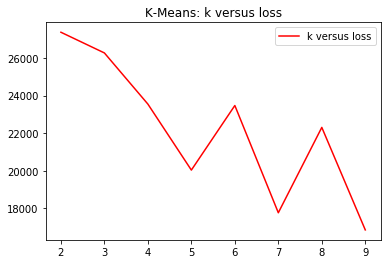

In [67]:
def plot_loss_versus_k(loss_list, k_list):
    plt.plot(k_list, loss_list, 'r', label='k versus loss')
    plt.legend()
    plt.title('K-Means: k versus loss')

plot_loss_versus_k(loss_log, k_list)

### For k = 2, plot the points using its first two features. Use two different colors or symbols to distinguish the two clusters

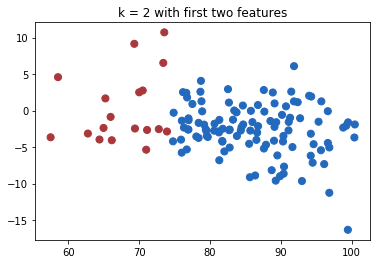

In [68]:
def plot_two_features(data, r):
    plt.scatter(data[:, 0], data[:, 1], c=r, s=50, cmap='vlag')
    plt.title('k = 2 with first two features')

plot_two_features(data_x, r_log[0])